<a href="https://colab.research.google.com/github/PTRRupprecht/Calcium_imaging_and_temporal_dispersion/blob/main/Temporal_dispersion_of_activity_from_deconvolved_calcium_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Temporal dispersion of activity from deconvolved calcium imaging**


Calcium imaging is temporally less precise than electrophysiology. [A recent study by Wei et al. (2020)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008198) showed that under the investigated imaging conditions, neuronal activity that appeared to have more or less clearly defined bouts from electrophysiological recordings appeared to be more continuous (like a smooth sequence) from calcium imaging data, even if those were deconvolved.

Is this indeed not possible to clearly distinguish smooth sequential activity patterns from more discrete bouts using calcium imaging? The short answer is, no; it is possible, under certain conditions.

I have described my approach to this question on this blog post. This Colaboratory Notebook is just a supplementary material to this blog posts, allowing any interested reader to replicate the analysis and to add their own analysis.

Briefly, the Notebook downloads the [Cascade](https://github.com/HelmchenLabSoftware/Cascade) toolbox into the Cloud-based environment, loads an appropriate global model [see the (preprint](https://www.biorxiv.org/content/10.1101/2020.08.31.272450v2), Fig. 3, for a description of this global model), uses one of the ground truth datasets to generate ground truth at a given noise level and then evaluates the dispersion of inferred spike rates in comparison to the ground truth.

##1. Download repository into the Colab Notebook

In [1]:
#@markdown The Github repository with all custom functions, the ground truth datasets and the pretrained models is copied to the environment of this notebook. This will take a couple of seconds.

#@markdown *Note: You can check the code underlying each cell by double-clicking on it.*

import os

# If in Colab and not yet downloaded, download GitHub repository and change working directory
if os.getcwd() == '/content':  
    !git clone https://github.com/HelmchenLabSoftware/Cascade
    os.chdir('Cascade')
    
# If executed as jupyter notebook on own computer, change to parent directory for imports
if os.path.basename( os.getcwd() ) == 'Demo scripts':
    %cd ..
    print('New working directory:', os.getcwd() )

Cloning into 'Cascade'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 2321 (delta 23), reused 0 (delta 0), pack-reused 2276
Receiving objects: 100% (2321/2321), 205.79 MiB | 41.38 MiB/s, done.
Resolving deltas: 100% (572/572), done.


##2. Import required python packages

In [2]:
#@markdown Downloads packages from public repository, and packages from Cascade.

%%capture
!pip install ruamel.yaml

# standard python packages
import os, warnings
import glob
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import ruamel.yaml as yaml

# cascade2p packages, imported from the downloaded Github repository
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

##3. Select a good pretrained model

In [3]:
#@markdown Gets a list of all available models.

cascade.download_model( 'update_models',verbose = 1)

yaml_file = open('Pretrained_models/available_models.yaml')
X = yaml.load(yaml_file, Loader=yaml.Loader)
list_of_models = list(X.keys())
print('\n List of available models: \n')
for model in list_of_models:
    print(model)

You can now check the updated available_models.yaml file for valid model names.
File location: /content/Cascade/Pretrained_models/available_models.yaml

 List of available models: 

GCaMP6f_mouse_30Hz_smoothing200ms
OGB_zf_pDp_7.5Hz_smoothing200ms
Global_EXC_5Hz_smoothing200ms
Global_EXC_5Hz_smoothing200ms_causalkernel
Global_EXC_6Hz_smoothing200ms
Global_EXC_6Hz_smoothing200ms_causalkernel
Global_EXC_7.5Hz_smoothing200ms
Global_EXC_7.5Hz_smoothing200ms_causalkernel
Global_EXC_10Hz_smoothing100ms
Global_EXC_10Hz_smoothing100ms_causalkernel
Global_EXC_10Hz_smoothing200ms
Global_EXC_10Hz_smoothing200ms_causalkernel
Global_EXC_12.5Hz_smoothing100ms
Global_EXC_12.5Hz_smoothing100ms_causalkernel
Global_EXC_12.5Hz_smoothing200ms
Global_EXC_12.5Hz_smoothing200ms_causalkernel
Global_EXC_15Hz_smoothing100ms
Global_EXC_15Hz_smoothing100ms_causalkernel
Global_EXC_15Hz_smoothing200ms
Global_EXC_15Hz_smoothing200ms_causalkernel
Global_EXC_17.5Hz_smoothing100ms
Global_EXC_17.5Hz_smoothing200ms
Globa

In [4]:
model_name = 'Global_EXC_30Hz_smoothing50ms'

cascade.download_model( model_name,verbose = 1)

Pretrained model was saved in folder "/content/Cascade/Pretrained_models/Global_EXC_30Hz_smoothing50ms"


##4. Resample ground truth at a given noise level

In [5]:
#@markdown Selects one of the ground truth datasets (GCaMP6f from Chen et al., 2013).

from cascade2p import utils

ground_truth_folders = glob.glob('Ground_truth/*')
ground_truth_folder = 'Ground_truth/DS09-GCaMP6f-m-V1'
ground_truth_folder

'Ground_truth/DS09-GCaMP6f-m-V1'

In [6]:
noise_level = 2.0
frame_rate = 30.0

In [7]:
#@markdown Resample the ground truth dataset to a given noise level and frame rate.

[X,Y] = utils.preprocess_groundtruth_artificial_noise_balanced([ground_truth_folder],0.5,64,0.5,noise_level,frame_rate,0.05*30,omission_list=[],permute=0,maximum_traces=5000000,verbose=3,replicas=0,causal_kernel=0)


Preprocessing dataset number 0
Resampling neuron 1 from a total of 11 neurons.
Resampling neuron 2 from a total of 11 neurons.
Resampling neuron 3 from a total of 11 neurons.
Resampling neuron 4 from a total of 11 neurons.
Resampling neuron 5 from a total of 11 neurons.
Resampling neuron 6 from a total of 11 neurons.
Resampling neuron 7 from a total of 11 neurons.
Resampling neuron 8 from a total of 11 neurons.
Resampling neuron 9 from a total of 11 neurons.
Resampling neuron 10 from a total of 11 neurons.
Resampling neuron 11 from a total of 11 neurons.
Reducing ground truth by a factor of approximately 0.
Number of neurons in the ground truth: 11
Shape of training dataset X: (230361, 64, 1)    Y: (230361, 1)


##5. Infer spike rates from calcium data

In [8]:
# X are the calcium data

spike_rates = cascade.predict( model_name, X[:,32,:].T ,threshold = 1)
spike_rates = spike_rates.T


 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 50 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 1 neurons and 230361 frames.
Noise levels (mean, std; in standard units): 2.03, 0.0

Predictions for noise level 2:
	... ensemble 0
29/29 [==============================] - 10s 13ms/step
	... ensemble 1
29/29 [==============================] - 0s 13ms/step
	... ensemble 2
29/29 [==============================] - 1s 14ms/step
	... ensemble 3
29/29 [==============================] - 0s 14ms/step
	... ensemble 4
29/29 [==============================] - 0s 14ms/step

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise lev

##6. Analyse results

In [9]:
# Find events in the ground truth that exceed a certain spike rate threshold

events = Y>0.5
event_indices = np.where(events)[0]
event_indices = np.flip(event_indices)

for i,index in enumerate(event_indices[:-2]):
    
    # Elimiate detected events if a event had been detected during the 2 past seconds
    if (index-event_indices[i+1] < 60):
        
        event_indices[i] = 0

event_indices = event_indices[event_indices>0]

In [10]:
# Write data (ground truth, predictions, raw dF/F) for time window around events into a matrix

nb_per_time_bin = np.int(np.floor(len(event_indices)/3)-1)

# Separate events into three bins; each bin is shifted by a different time to generate discrete bouts of activity
separation_points = [1,1+nb_per_time_bin,1+2*nb_per_time_bin]

duration = 30*6
arrays = np.zeros((duration, nb_per_time_bin*3))
array_predictions = np.zeros((duration, nb_per_time_bin*3))
array_dFF = np.zeros((duration, nb_per_time_bin*3))

for k in range(arrays.shape[1]):
    
    if k < separation_points[1]:
        offset = int(duration/2-0.5*30)
    elif k < separation_points[2]:
        offset = int(duration/2)
    else:
        offset = int(duration/2+0.5*30)
    
    arrays[:,k] = Y[event_indices[k]-offset:event_indices[k]-offset+duration,0]
    array_predictions[:,k] = spike_rates[event_indices[k]-offset:event_indices[k]-offset+duration,0]
    array_dFF[:,k] = X[event_indices[k]-offset:event_indices[k]-offset+duration,32,0]


##7. Plot results of analysis

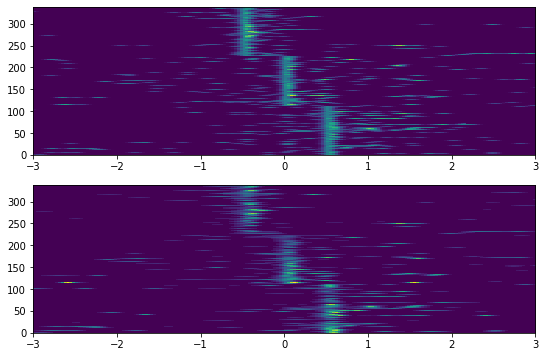

In [11]:
plt.rcParams['figure.figsize'] = (9.0, 6.0)
import matplotlib.pyplot as plt

plt.figure(31223)
plt.subplot(2,1,1)
plt.imshow(arrays.T,interpolation="none",aspect='auto',extent=[-3,3,0,array_predictions.shape[1]])
plt.subplot(2,1,2)
plt.imshow(array_predictions.T,interpolation="none",aspect='auto',extent=[-3,3,0,array_predictions.shape[1]])

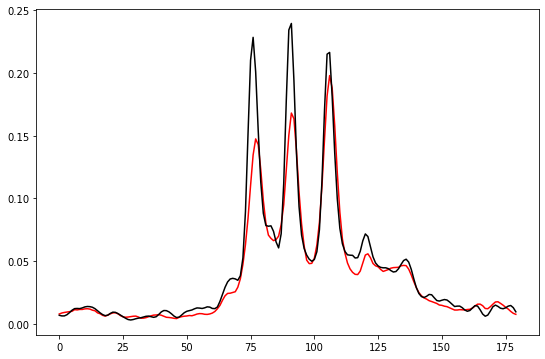

In [15]:
plt.figure(44)
plt.plot(np.mean(array_predictions,axis = 1),'r')
plt.plot(np.mean(arrays,axis = 1),'k')